In [1]:
import os, sys

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
sys.path.append(str(Path.cwd().resolve().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import weight_norm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from preprocess import VN30, TARGETS, preprocess_v2

# Bước 1: Tiền xử lý dữ liệu

In [2]:
train_loader, valid_loader, test_loader, scaler = preprocess_v2('ACB', 'rnn', verbose=True)

Train shape: torch.Size([1094, 30, 4]), torch.Size([1094, 4])
Valid shape: torch.Size([121, 30, 4]), torch.Size([121, 4])


In [3]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_layers, hidden_dim, fc_dim, output_dim, dropout=0.2):
        super().__init__()
        # LSTM với dropout giữa các layer (chỉ active khi n_layers > 1)
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )
        # Dropout sau khi lấy last-step output
        self.dropout = nn.Dropout(dropout)
        # FC phụ: hidden_dim → fc_dim → output_dim
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, output_dim)
        )

    def forward(self, x):
        # x: (batch_size, seq_len, n_features)
        lstm_out, _ = self.lstm(x)
        # lstm_out: (batch_size, seq_len, hidden_dim)
        last = lstm_out[:, -1, :]
        # last: (batch_size, hidden_dim)
        dropped = self.dropout(last)
        # dropped: (batch_size, hidden_dim)
        y_pred = self.fc(dropped)
        # y_pred: (batch_size, output_dim)
        return y_pred

In [12]:
model = LSTM(
	n_features=4,
	n_layers=1,
	hidden_dim=64,
	fc_dim=32,
	output_dim=4,
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion = nn.SmoothL1Loss()

In [ ]:
best_val_loss = float('inf')
n_epochs = 200

for epoch in range(1, n_epochs + 1):
    # --- train ---
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        preds = model(X_batch)
        loss  = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch, y_batch
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item() * X_batch.size(0)
    val_loss /= len(valid_loader.dataset)

    scheduler.step()

    # --- checkpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'checkpoints/lstm.pth')

    if epoch % 10 == 0 or epoch == n_epochs:
        print(f"Epoch {epoch:3d}/{n_epochs}: "
              f"Train Loss = {train_loss:.6f}, "
              f"Valid Loss = {val_loss:.6f}, "
              f"Best Val Loss = {best_val_loss:.6f}, "
			  f"LR = {optimizer.param_groups[0]['lr']:.6f}")

Epoch  10/200: Train Loss = 0.016679, Valid Loss = 0.005080, Best Val Loss = 0.002370, LR = 0.000800
Epoch  20/200: Train Loss = 0.013103, Valid Loss = 0.006141, Best Val Loss = 0.001706, LR = 0.000640
Epoch  30/200: Train Loss = 0.012245, Valid Loss = 0.001708, Best Val Loss = 0.001337, LR = 0.000512
Epoch  40/200: Train Loss = 0.011601, Valid Loss = 0.001900, Best Val Loss = 0.001104, LR = 0.000410
Epoch  50/200: Train Loss = 0.011426, Valid Loss = 0.002768, Best Val Loss = 0.001104, LR = 0.000328
Epoch  60/200: Train Loss = 0.010784, Valid Loss = 0.002194, Best Val Loss = 0.001104, LR = 0.000262
Epoch  70/200: Train Loss = 0.011815, Valid Loss = 0.001859, Best Val Loss = 0.001014, LR = 0.000210
Epoch  80/200: Train Loss = 0.011011, Valid Loss = 0.001107, Best Val Loss = 0.001008, LR = 0.000168
Epoch  90/200: Train Loss = 0.011816, Valid Loss = 0.001562, Best Val Loss = 0.000934, LR = 0.000134
Epoch 100/200: Train Loss = 0.010908, Valid Loss = 0.001195, Best Val Loss = 0.000934, LR =

In [14]:
model.load_state_dict(torch.load('checkpoints/lstm.pth', map_location='cpu'))
model.eval()

# Thu thập dự đoán và nhãn
all_preds   = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch
        preds = model(X_batch).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_batch.numpy())

all_preds   = np.vstack(all_preds)   # (n_samples, 5)
all_targets = np.vstack(all_targets)

# Inverse scaling
all_preds_inv   = scaler.inverse_transform(all_preds)
all_targets_inv = scaler.inverse_transform(all_targets)

# Tính metrics
r2   = r2_score(all_targets_inv, all_preds_inv, multioutput='uniform_average')
mape = mean_absolute_percentage_error(all_targets_inv, all_preds_inv) * 100

print(f"Test R²: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}%")

Test R²: 0.7792
Test MAPE: 1.6768%


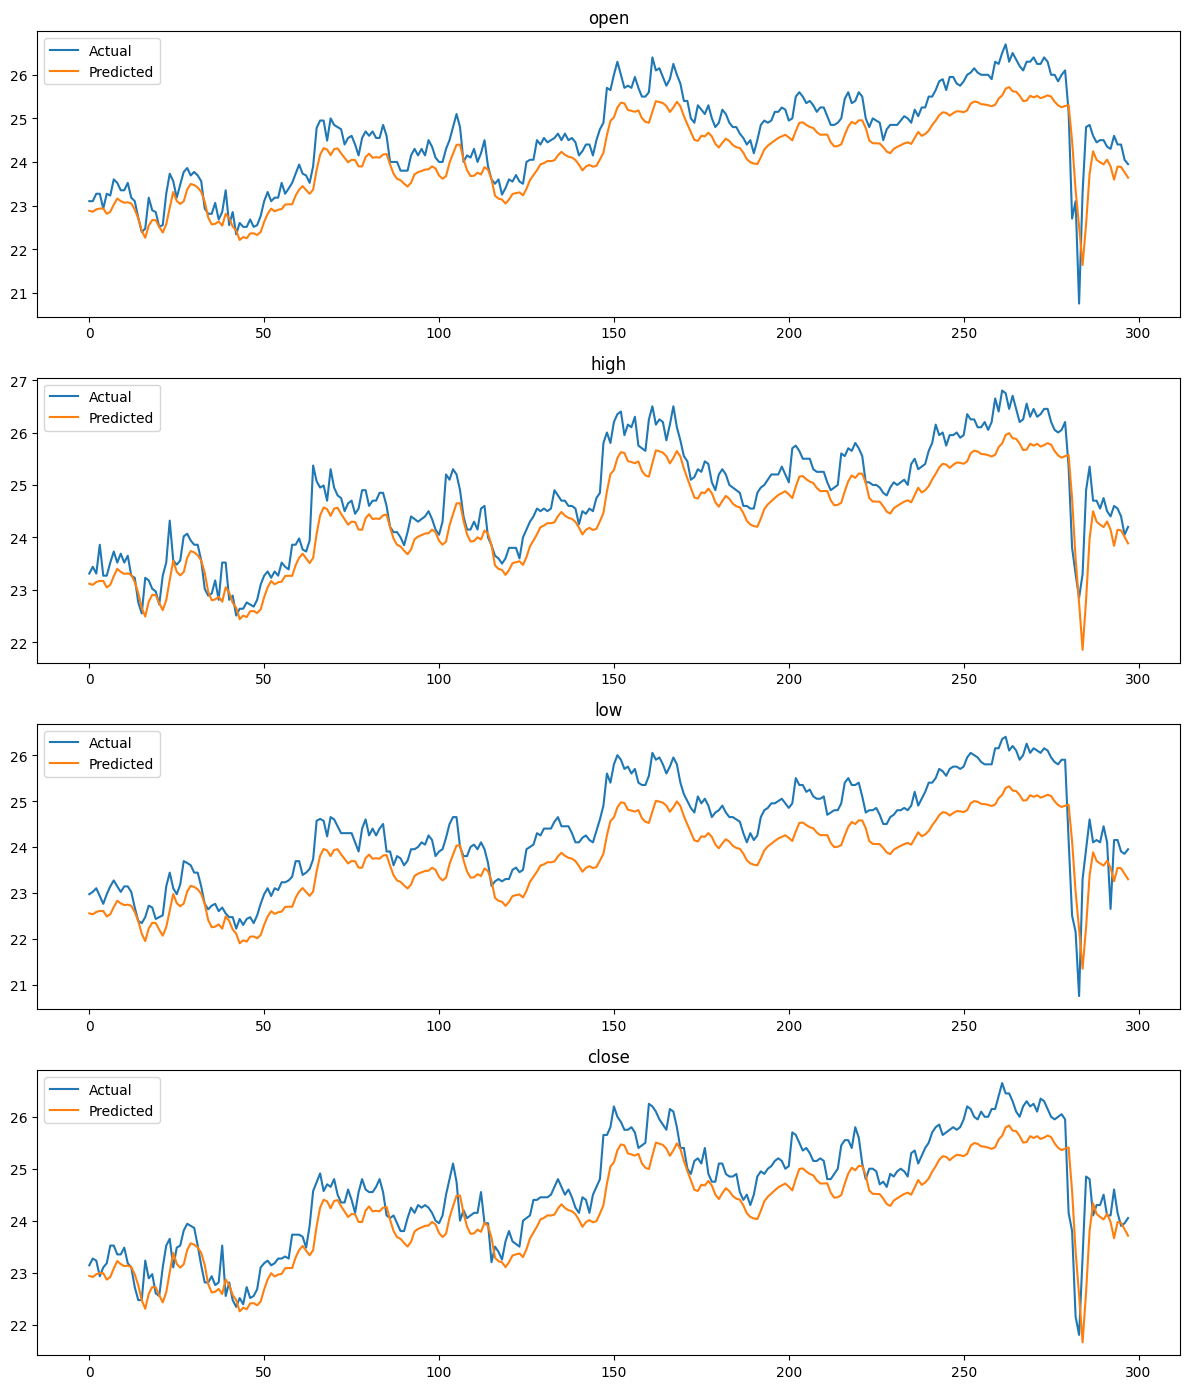

In [11]:
n = all_targets_inv.shape[1]

plt.figure(figsize=(12, 14))
for i in range(n):
    ax = plt.subplot(n, 1, i + 1)
    ax.plot(all_targets_inv[:, i], label='Actual')
    ax.plot(all_preds_inv[:, i],   label='Predicted')
    ax.set_title(TARGETS[i])
    ax.legend(loc='best')

plt.tight_layout()
plt.show()